![Cardio Image](https://img.freepik.com/free-photo/human-heart-design_1048-1855.jpg?size=626&ext=jpg&ga=GA1.1.110088987.1677679311&semt=ais)
<h1>Cardio Catch Diseases </h1>

## 0.0 - Planning and Business Knowledge

<h4>0.1. Business Problem.</h4>
<p>Cardio Catch Diseases is a company specialized in detecting heart disease in the early stages. Its business model lies in offering an early diagnosis of cardiovascular disease for a certain price.

<h4>0.2. Objective</h4>
    <li>Growth diagnostic precision and make stable.</li>


<h4>0.3. Justification</h4>
    <li>Currently, it's a manual diagnostic by humans.</li>
    <li>Low Precision, between 55% and 65%.</li>
    <li>Hight cost around one thousand (1.000,00) Reals with operators and machines costing.</li>
    <li>The revenue is variable accordingly precision from diagnostics, 500 each 5% above than 50% precision.</li>
    
<h4>0.4. Solution Proposal</h4>
    <lu>
        <li>Collect data from <a href="https://www.kaggle.com/sulianova/cardiovascular-disease-dataset">Kaggle</a></li>
        <li>Build a binary classification with <b>Machine Learning</b> or <b>statistics models</b> solution to diseases prediction.</li>
    </lu>
    
<h4>0.5 Report</h4>
    <lu>
        <li>What the precision accuracy from the solution?.</li>
        <li>How much profit you will get because of that solution?</li>
        <li>how reliable is the solution?</li>
    </lu>

<h4>0.6 Premises</h4>
    <lu>
        <li>Drop inconsistent data from low pressure .</li>
        <li>Drop inconsistent data from high pressure</li>
        <li>Drop inconsistent data from height</li>
        <li>Drop inconsistent data from weight</li>
    </lu>

## 1.0 - Imports

In [215]:
# !pip install boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1.1 - Libraries

In [216]:
import pandas as pd
import numpy as np

from random import sample as sp
from   pandas_profiling      import ProfileReport #conda install -c conda-forge ydata-profiling


# # Database CRUD
from sqlalchemy import create_engine
import sqlite3

# # Data Transformation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

# # visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.stats import pointbiserialr


# # Machine Learning, selection and split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
import pickle
from boruta import BorutaPy
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score


# #Configurations
from IPython.display import Image
from IPython.display import HTML
import warnings


### 1.2 - Funcions

In [217]:




# Calculating Scores to classification 
def metrics_score(y_valid, y_hat, mdl_name:str):
    '''
        y_hat:    is the prediction array
        y_valid:  is the true targe array or series
        mdl_name: is the name of machine learning model
        
        Accuracy formula  -->   accuracy   = np.mean(y_hat == y_valid)
        Precision formula -->   precision  = positive_true/(positive_true+positive_false)      
        Recall formula    -->   recall     = positive_true/(positive_true+negative_false)
        
        Return -->> mdl_name, accuracy, precision, recall
        
    '''
    accuracy = accuracy_score(y_valid, y_hat)
    precision = precision_score(y_valid, y_hat)
    recall = recall_score(y_valid, y_hat)
    
    return pd.DataFrame([[mdl_name, accuracy, precision, recall, 
                        ]], 
                        columns=['mdl_name', 'accuracy', 'precision', 'recall' 
                                 ])
    


# Jupyter configuring to better experience
def jupyter_settings():
    %matplotlib inline
    %pylab inline
        
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,9]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container{width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
jupyter_settings()  

# To hide warning messages
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


### 1.3 - Data Collect - CSV

In [218]:
# Loading dataset
# from google import colab as cl
# file_upload=cl.files.upload()
#df = pd.read_csv(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\datasets\cardio_train.csv', sep=';')
df = pd.read_csv('/content/cardio_train.csv', sep=';')

#Test split
df, df_test = train_test_split(df)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
32483,46395,20631,1,153,83.0,120,70,1,1,0,0,1,0
43648,62365,19890,1,165,69.0,140,90,2,1,0,0,0,0
22806,32571,19082,1,161,98.0,140,90,1,1,0,0,1,1
8210,11712,14422,1,171,80.0,110,60,1,2,1,1,1,0
43987,62847,21209,1,159,65.0,150,90,1,1,0,0,0,1


### 1.4 - Creating Datawerehouse

##### 1.4.1 - Rename Columns

In [219]:
# Old columns
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [220]:
# Rewriting columns names and replace then
new_col = ['id', 'age', 'gender', 'height', 'weight', 'hight_pressure', 'low_pressure',
       'cholesterol', 'glucose', 'smoker', 'alcohol', 'active', 'cardio']
df.columns = new_col
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'hight_pressure',
       'low_pressure', 'cholesterol', 'glucose', 'smoker', 'alcohol', 'active',
       'cardio'],
      dtype='object')

##### 1.4.2 - Database

In [221]:
# creating database
path_local="C:/Users/Utente77/repos/cardio_catch_disease_PA001/"
engine_db = create_engine(f"sqlite:////{path_local}/ccd.db", echo=False)
conn = sqlite3.Connection('cardio_disease.db')
cursor = conn.cursor()

# create table
query = '''CREATE TABLE IF NOT EXISTS patients(
                                id INTEGER,
                                age INTEGER,
                                gender INTEGER,
                                height INTEGER,
                                weight INTEGER,
                                hight_pressure INTEGER,
                                low_pressure INTEGER,
                                cholesterol INTEGER,
                                glucose INTEGER,
                                smoker INTEGER,
                                alcohol INTEGER,
                                active INTEGER,
                                cardio INTEGER
                                )'''

cursor.execute(query)
#engine = engine_db()
df.to_sql('patients', con=conn, if_exists='append', index=False)



52500

#### 1.4.3 - Data Collect from Database

In [222]:
# Selecting data
query="""
    SELECT *
    FROM patients;

"""
df=pd.read_sql_query(query,conn)


## 2.0 - Descriptive Analysis

### 2.1 - Dimensions

In [223]:
# Printing the data dimensions, how much rows and columns
print(f'{df.shape[0]} linhas.')
print(f'{df.shape[1]} colunas.')

210000 linhas.
13 colunas.


### 2.2 - Datatype and NaN fillout

In [224]:
# Columns Datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210000 entries, 0 to 209999
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              210000 non-null  int64  
 1   age             210000 non-null  int64  
 2   gender          210000 non-null  int64  
 3   height          210000 non-null  int64  
 4   weight          210000 non-null  float64
 5   hight_pressure  210000 non-null  int64  
 6   low_pressure    210000 non-null  int64  
 7   cholesterol     210000 non-null  int64  
 8   glucose         210000 non-null  int64  
 9   smoker          210000 non-null  int64  
 10  alcohol         210000 non-null  int64  
 11  active          210000 non-null  int64  
 12  cardio          210000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 20.8 MB


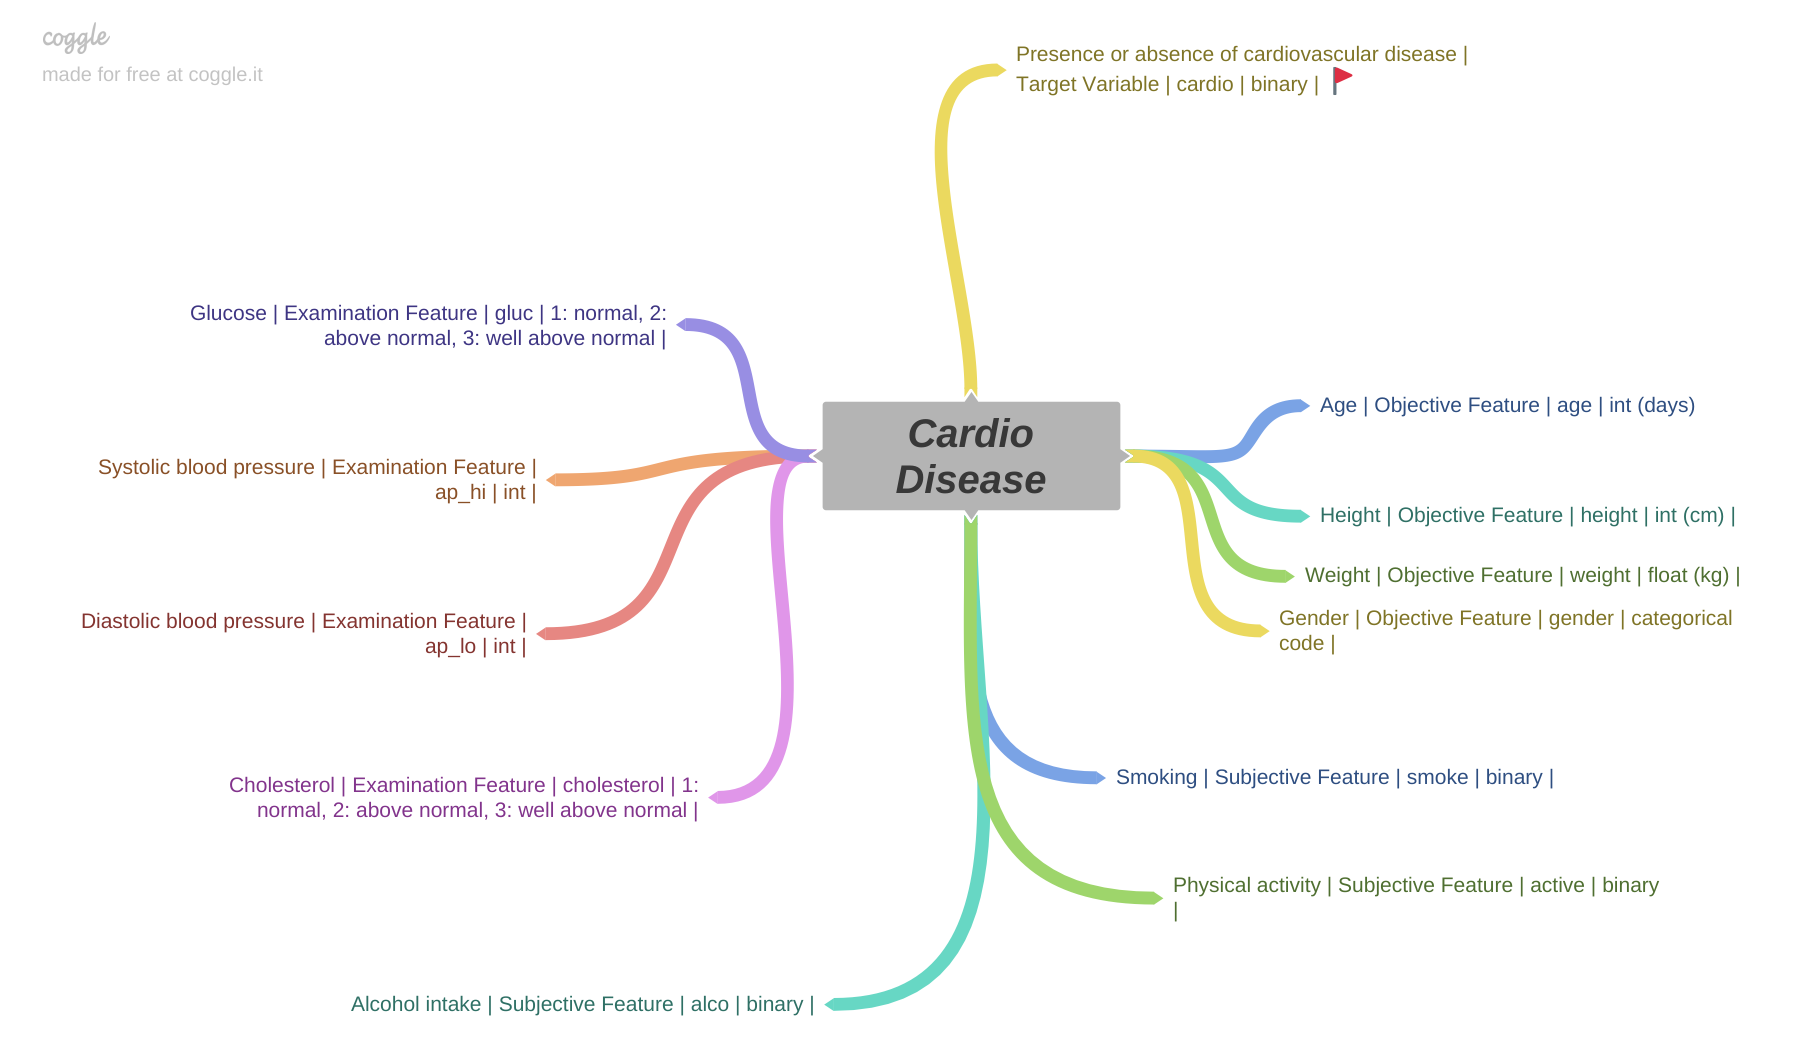

In [225]:
Image('/content/Cardio_Disease.png')

In [226]:
# age - change days to year old
df['age'] = (df['age'] / 365).astype('int')

# height - change centimeters to meters
df['height'] = (df['height'] / 100)

aux=df.isna().sum().sort_values(ascending=False)
aux1=df.isna().sum().sort_values(ascending=False)/df.shape[0]*100

na=pd.concat([aux,aux1],axis=1)
na.columns=['NaN', 'NaN %']
na

,NaN,NaN %
id,0,0.0
age,0,0.0
gender,0,0.0
height,0,0.0
weight,0,0.0
hight_pressure,0,0.0
low_pressure,0,0.0
cholesterol,0,0.0
glucose,0,0.0
smoker,0,0.0


### 2.3 - Data Description

In [227]:
# profile=ProfileReport(df, title="Pandas Profiling Report")
# profile.to_file(r"C:\Users\Utente77\repos\cardio_catch_disease_PA001\img\report.html")
# profile

In [228]:
num_attributes = df.select_dtypes( include=['int64', 'int32','float64'] )
cat_attributes = df.select_dtypes( exclude=['int64', 'int32','float64', 'datetime64[ns]'] )

In [229]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T.drop('id', axis=1)
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T.drop('id', axis=1)

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T.drop('id', axis=1) 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T.drop('id', axis=1) 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T.drop('id', axis=1) 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T.drop('id', axis=1) 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T.drop('id', axis=1) 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T.drop('id', axis=1) 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,29.00,64.0,35.00,52.833371,53.00,6.766097,-0.304543,-0.819897
1,gender,1.00,2.0,1.00,1.349000,1.00,0.476654,0.633588,-1.598582
2,height,0.55,2.5,1.95,1.643576,1.65,0.081889,-0.592488,7.447568
3,weight,10.00,200.0,190.00,74.215019,72.00,14.394045,1.010972,2.584386
4,hight_pressure,-150.00,16020.0,16170.00,128.416419,120.00,137.071860,95.273117,9526.236834
5,low_pressure,-70.00,11000.0,11070.00,96.197076,80.00,183.086320,32.246093,1458.598257
6,cholesterol,1.00,3.0,2.00,1.366852,1.00,0.680193,1.587133,0.994140
7,glucose,1.00,3.0,2.00,1.226762,1.00,0.572819,2.395425,4.281789
8,smoker,0.00,1.0,1.00,0.087952,0.00,0.283226,2.909698,6.466405
9,alcohol,0.00,1.0,1.00,0.053671,0.00,0.225368,3.960912,13.688957


#### 2.3.1  Inconsistent numbers of **hight pressure** and **low pressure** 


In [230]:

print(f'''{df[(df['low_pressure'] < 20) | (
    df['low_pressure'] > 150)].shape[0]} inconsistent rows on low_pressure.''')
print(f'''{df[(df['hight_pressure'] < 40) | (
    df['hight_pressure'] > 300)].shape[0]} inconsistent rows on hight_pressure. ''')

# filtering data without inconsistence data
df = df[(df['low_pressure'] >= 20) & (df['low_pressure'] <= 150)]
df = df[(df['hight_pressure'] >= 40) & (df['hight_pressure'] <= 300)]

2971 inconsistent rows on low_pressure.
705 inconsistent rows on hight_pressure. 


#### 2.3.2 Inconsistent numbers of **height**


In [231]:
print(f'''{df[df['height'] <= 1.45].shape[0]} inconsistent rows on height.''')

# Data filtering possible incosistent data by height 
df = df[df['height'] > 1.45]


1523 inconsistent rows on height.


In [232]:
# Descriptive statistics after filters

describe = df.describe().T.drop('id', axis=0)
describe['range'] = describe['max'] - describe['min']
describe['kurtosis'] = describe.T.kurtosis()
describe['skew'] = describe.T.skew()
describe

,count,mean,std,min,25%,50%,75%,max,range,kurtosis,skew
age,204849.0,52.809362,6.766599,29.00,48.00,53.00,58.0,64.0,35.00,8.999998,3.162277
gender,204849.0,1.349867,0.476929,1.00,1.00,1.00,2.0,2.0,1.00,9.000000,3.162278
height,204849.0,1.645725,0.076735,1.46,1.59,1.65,1.7,2.5,1.04,9.000000,3.162278
weight,204849.0,74.184660,14.251167,11.00,65.00,72.00,82.0,200.0,189.00,8.999976,3.162271
hight_pressure,204849.0,126.600647,16.738308,60.00,120.00,120.00,140.0,240.0,180.00,8.999978,3.162271
low_pressure,204849.0,81.332923,9.588129,20.00,80.00,80.00,90.0,150.0,130.00,8.999989,3.162274
cholesterol,204849.0,1.364195,0.678651,1.00,1.00,1.00,1.0,3.0,2.00,9.000000,3.162278
glucose,204849.0,1.226215,0.572530,1.00,1.00,1.00,1.0,3.0,2.00,9.000000,3.162278
smoker,204849.0,0.088260,0.283674,0.00,0.00,0.00,0.0,1.0,1.00,9.000000,3.162278
alcohol,204849.0,0.053576,0.225180,0.00,0.00,0.00,0.0,1.0,1.00,9.000000,3.162278


## 3.0 - Feature Engineering

In [233]:
df1=df.copy(())

In [234]:
# A difference between systolic and diastolic arterial pressure, 

df1['difference'] = df1['hight_pressure'] - df1['low_pressure'] # A difference between systolic and diastolic arterial pressure
df1['convergent'] = df1['difference'].apply(lambda x: 1 if x <= 30 else 0) # lesser than 30mmhg called convergent 
df1['divergent'] = df1['difference'].apply(lambda x: 1 if x >= 60 else 0)# and upper than 60mmhg called divergent 

In [235]:
# BMI calculus and slices in four levels
df1['bmi'] = (df1['weight']/(df1['height'] * df1['height']))
df1['bmi_level'] = df1['bmi'].apply(lambda x: 
                                              '0' if x <= 18.5 else
                                              '1'      if x >  18.5 and x <= 24.9 else
                                              '2'  if x >= 25.0 and x <= 29.9 else
                                              '3')

In [236]:
# Hypertension and Hipotension binary
df1['hypertension'] = df1.apply(lambda x: 1 if x[4] >=140 and x[5] >= 90 else 0, axis=1)
df1['hypotension'] = df1.apply(lambda x: 1 if x[4] <=90 and x[5] <= 60 else 0, axis=1)

In [237]:
# Slicing ages with three ranges
df1['age_range'] = df1['age'].apply(lambda x: 1    if x <= 50 
                                                   else 2   if x >= 51 and x <= 59 
                                                   else 3 if x >= 60 
                                                   else x)

In [238]:
df1['weight_range'] = df1['weight'].apply(
    lambda x:   0.50 if x <= 50  else
                0.75 if x >= 51  and x <= 75 else
                1.00 if x >= 76  and x <= 100 else
                1.25 if x >= 101 and x <= 125 else
                1.50 if x >= 126 and x <= 150 else
                1.75 if x >= 151 and x <= 175 else 2.00)

## 4.0 - Data Filtering

In [239]:
df1.head()

,id,age,gender,height,weight,hight_pressure,low_pressure,cholesterol,glucose,smoker,alcohol,active,cardio,difference,convergent,divergent,bmi,bmi_level,hypertension,hypotension,age_range,weight_range
0,93308,62,1,1.56,59.0,115,70,3,1,0,0,0,1,45,0,0,24.243918,1,0,0,3,0.75
1,60646,60,2,1.70,66.0,140,90,2,1,0,0,1,1,50,0,0,22.837370,1,0,0,3,0.75
2,42310,48,2,1.70,96.0,130,80,1,1,0,0,1,0,50,0,0,33.217993,3,0,0,1,1.00
3,48119,59,1,1.68,66.0,120,80,1,1,0,0,1,1,40,0,0,23.384354,1,0,0,2,0.75
4,12011,54,1,1.56,58.0,130,80,1,1,0,0,1,1,50,0,0,23.833005,1,0,0,2,0.75


In [240]:
df1.shape

(204849, 22)

## 5.0 - EDA - Explolatory Data Analysis

In [241]:
df2=df1.copy()

### 5.1 - Univariate Analysis

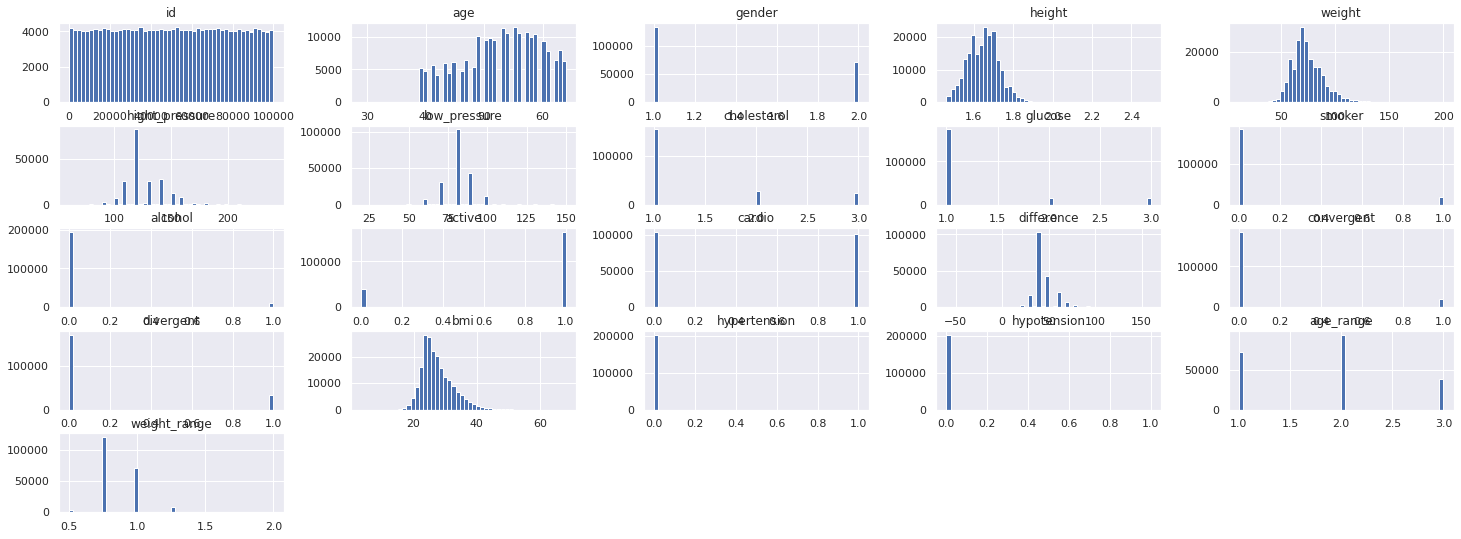

In [242]:
# Distribution from all data
df2.hist(bins=50);

### 5.2 - Bivariate Analysis

##### 5.2.1 - How more active, less diseases
False

In [243]:
df2[['cardio','active']].groupby('cardio').value_counts(normalize=True ).reset_index()

,cardio,active,0
0,0,1,0.818536
1,0,0,0.181464
2,1,1,0.788218
3,1,0,0.211782


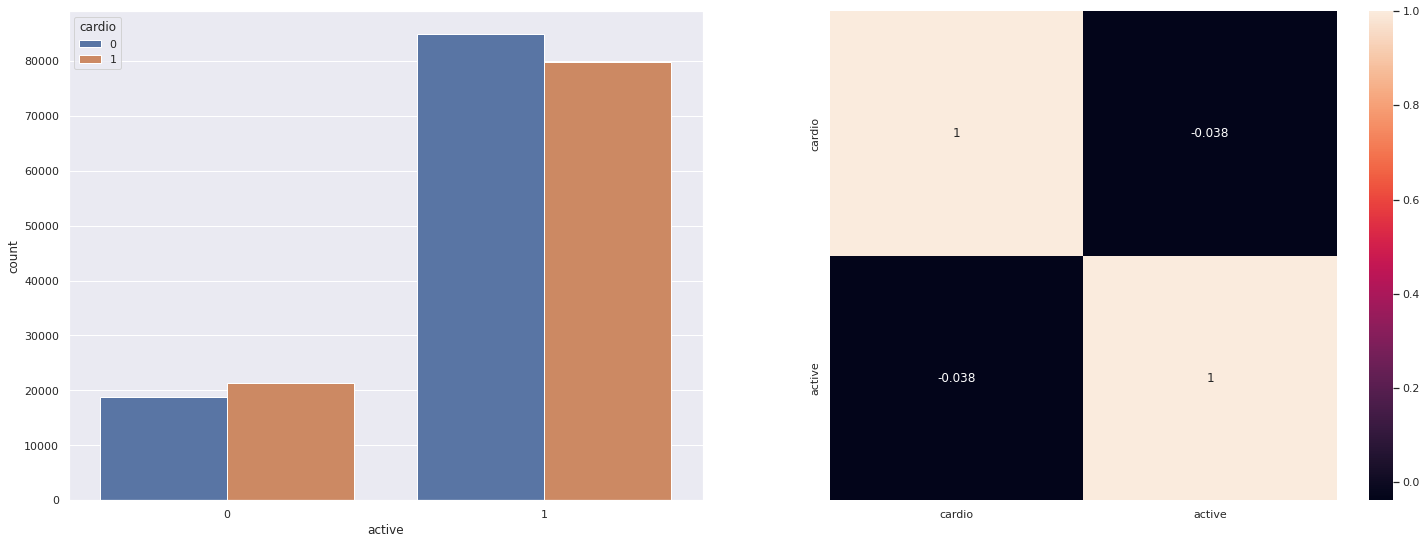

In [244]:
subplot(1,2,1)
sns.countplot(hue='cardio', x='active', data=df2);

subplot(1,2,2)
sns.heatmap(df2[['cardio','active']].corr(method='pearson'), annot=True);


##### 5.2.2 - Cholesterou over level I, more risk
 True (perarson >0.2)

In [245]:
df2[['cardio','cholesterol']].groupby('cardio').value_counts(normalize=True ).reset_index()

,cardio,cholesterol,0
0,0,1,0.838206
1,0,2,0.107786
2,0,3,0.054009
3,1,1,0.660348
4,1,3,0.176419
5,1,2,0.163232


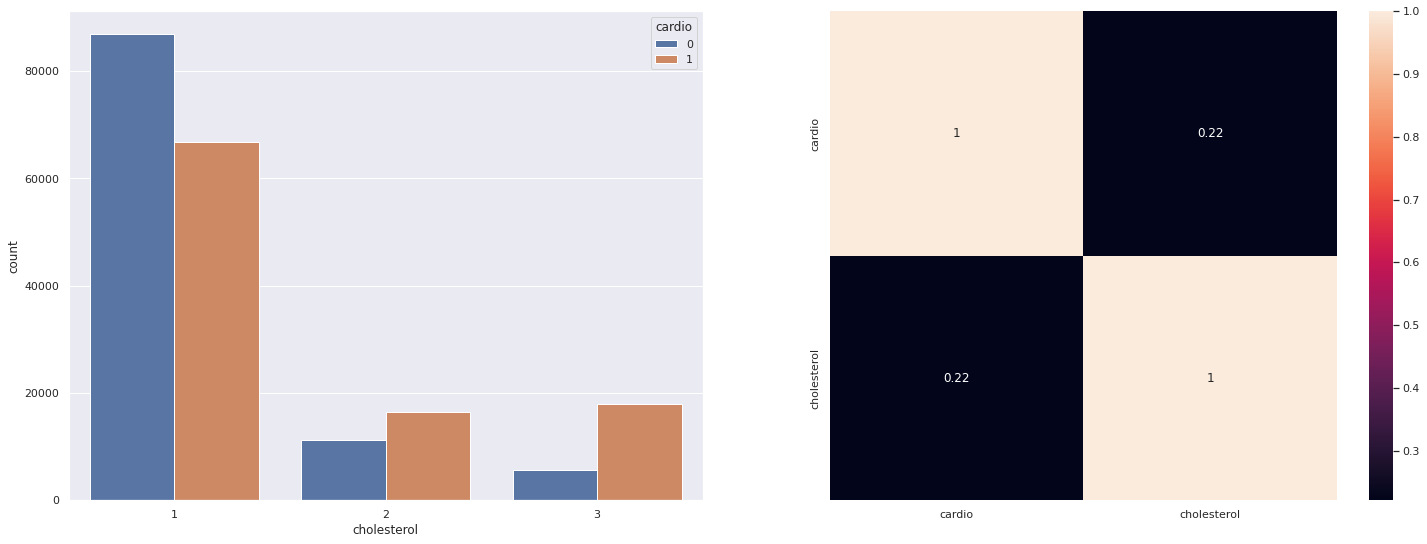

In [246]:
plt.subplot(1,2,1)
sns.countplot(hue='cardio', x='cholesterol', data=df2);

plt.subplot(1,2,2)
sns.heatmap(df2[['cardio','cholesterol']].corr(method='pearson'), annot=True);


##### 5.2.3 - How more clucose, more risk
   False

The correlation it's so low, insignificat to model

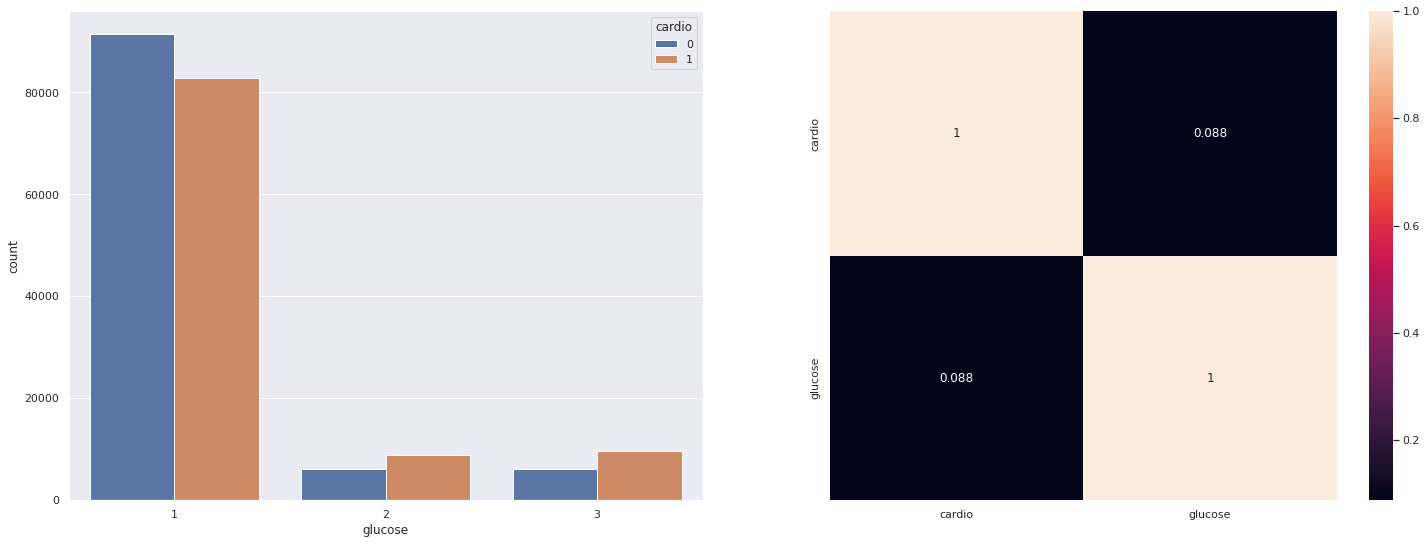

In [247]:
plt.subplot(1,2,1)
sns.countplot(hue='cardio', x='glucose', data=df2);

plt.subplot(1,2,2)
sns.heatmap(df2[['cardio','glucose']].corr(method='pearson'), annot=True);

##### 5.2.4 - How more older, more risk
   True (perarson >0.2)

following the years it's more count and more avarage pear year old, low correlation, but, probly it's important to model

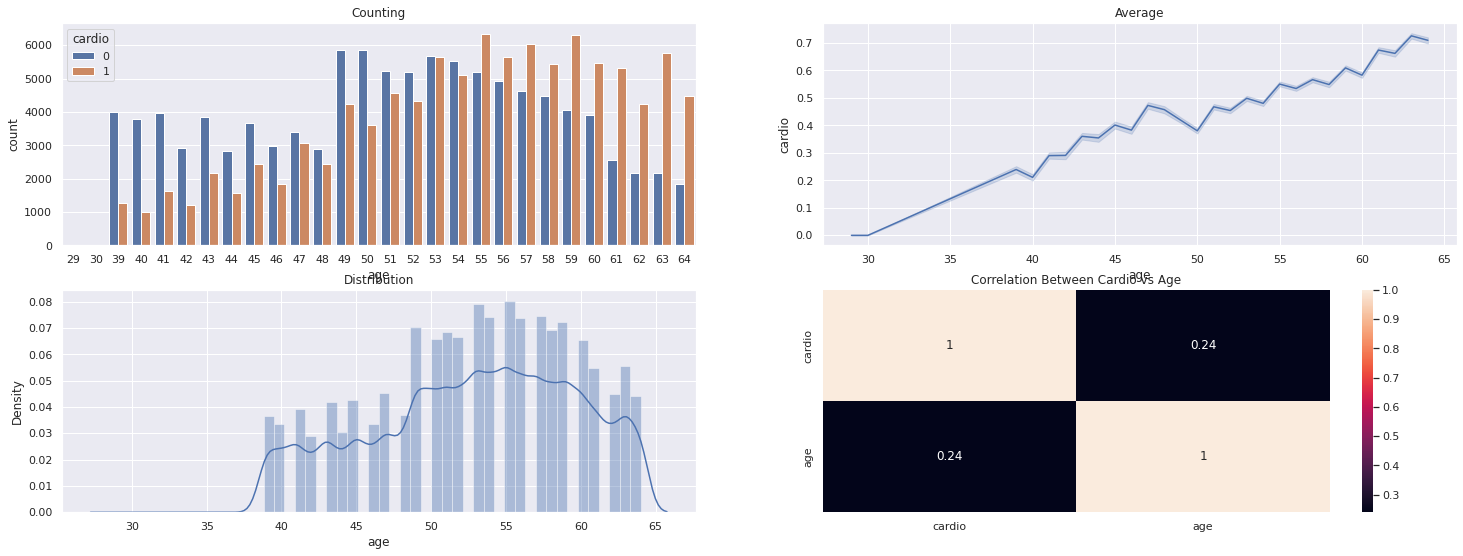

In [248]:
subplot(2,2,1)
plt.title('Counting')
sns.countplot(x='age', hue='cardio', data=df2);

subplot(2,2,2)
plt.title('Average')
sns.lineplot(data=df2, x='age', y='cardio', estimator='mean');

subplot(2,2,3)
plt.title('Distribution')
sns.distplot(df2['age']);

subplot(2,2,4)
plt.title('Correlation Between Cardio vs Age')
sns.heatmap(df2[['cardio', 'age']].corr('pearson'), annot=True);

##### 5.2.5 - Over 60 year old with Hypertension, more risk
   False

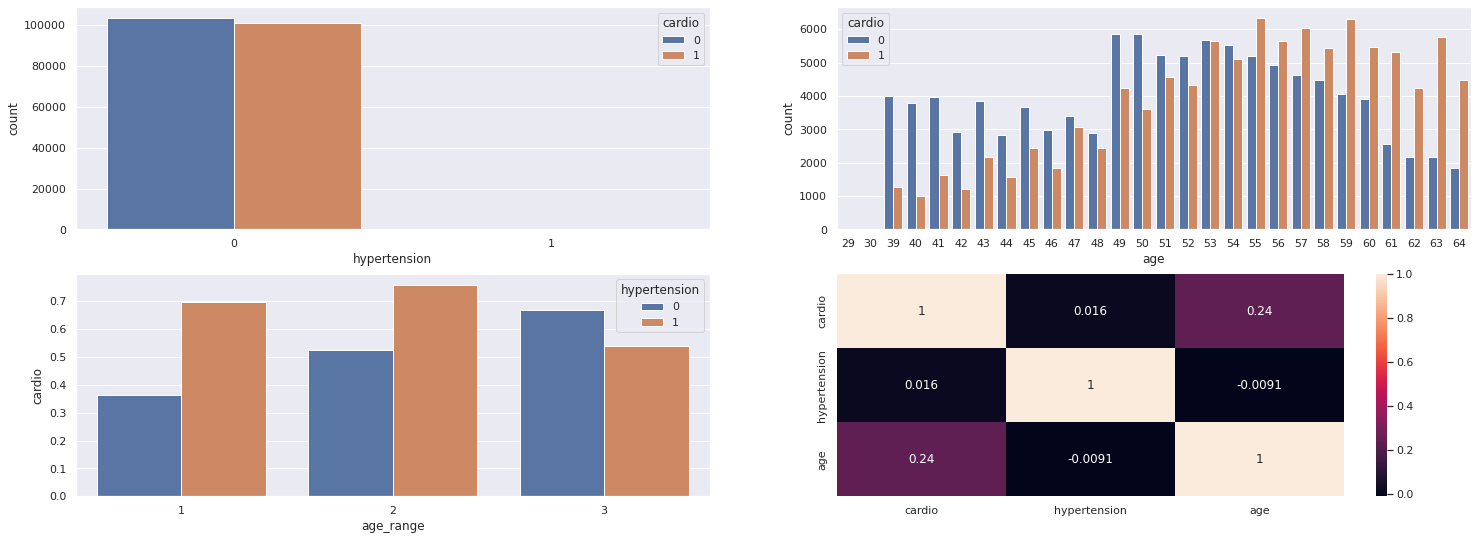

In [249]:
aux = df2[['age_range', 'cardio']].groupby('age_range').mean().reset_index()
aux1 = df2[['cardio', 'age_range', 'hypertension']]

plt.subplot(2,2,1)
sns.countplot(hue='cardio', x='hypertension', data=aux1);

plt.subplot(2,2,2)
sns.countplot(x='age', hue='cardio', data=df2);

# Average incidence of diseases by hypertension and over 60 year.
subplot(2,2,3)
aux = df2[['hypertension', 'cardio', 'age_range']].groupby(['hypertension', 'age_range']).mean().reset_index()
sns.barplot(x='age_range', y='cardio', hue='hypertension', data=aux);

subplot(2,2,4)
sns.heatmap(df2[['cardio', 'hypertension', 'age']].corr('pearson'), annot=True);

##### 5.2.6 - 60 year old with Hypotension, more risk
   False

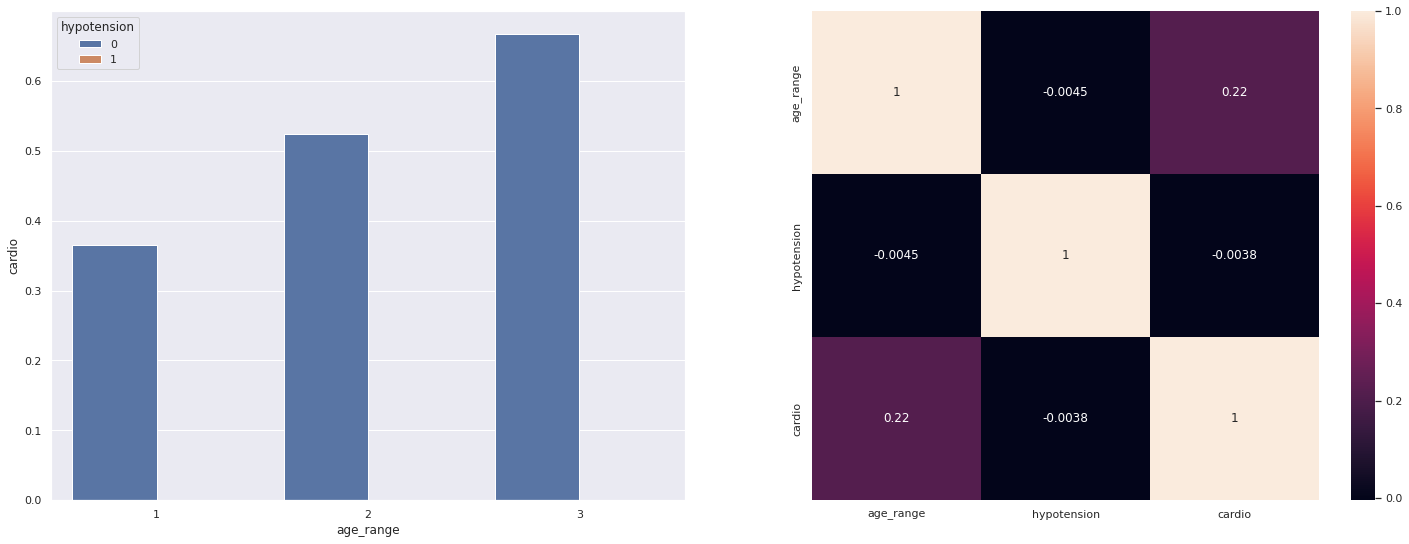

In [250]:
aux = df2[['hypotension', 'age_range', 'cardio']].groupby(
    ['hypotension', 'age_range']).mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='age_range', y='cardio', hue='hypotension', data=aux);


plt.subplot(1,2,2)
sns.heatmap(df2[['age_range', 'hypotension', 'cardio']].corr('pearson'), annot=True);

##### 5.2.7 - 60 year old, more risk
   False

In [251]:
df2[['cardio','age_range']].groupby('cardio').value_counts(normalize=True ).reset_index()

,cardio,age_range,0
0,0,1,0.444423
1,0,2,0.433334
2,0,3,0.122243
3,1,2,0.488897
4,1,1,0.261241
5,1,3,0.249862


##### 5.2.8 - Divergent AP, more risk
   True - Relevant variable

<Axes: >

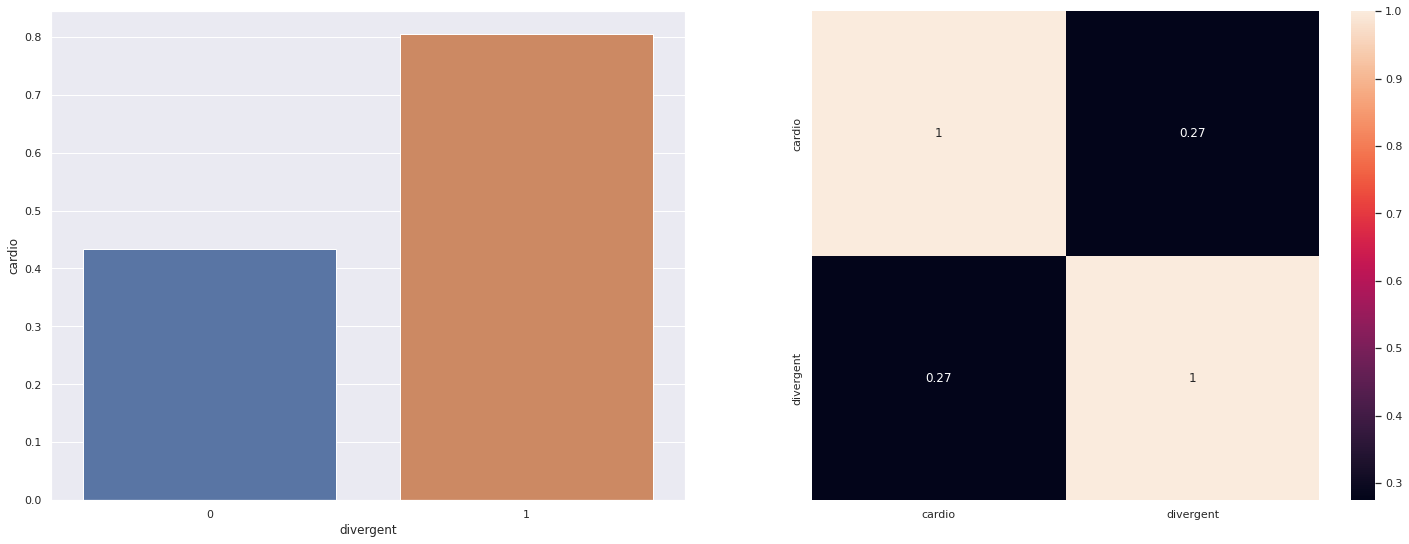

In [252]:
aux = df2[['divergent', 'cardio']].groupby('divergent').mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='divergent', y='cardio', data=aux)

plt.subplot(1,2,2)
sns.heatmap(df2[['cardio', 'divergent']].corr('pearson'), annot=True)

##### 5.2.9 - Convergent AP, more risk
   False

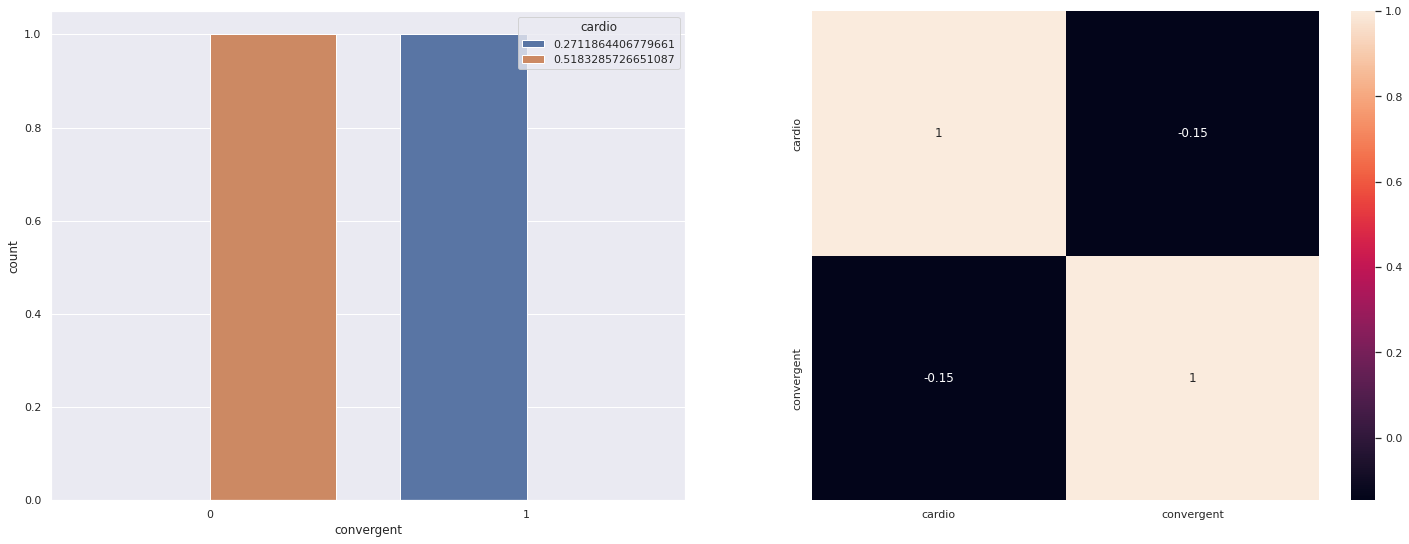

In [253]:
plt.subplot(1,2,1)
sns.countplot(x='convergent', hue='cardio',
    data=df2[['cardio', 'convergent']].groupby('convergent').mean().reset_index());

plt.subplot(1,2,2)
sns.heatmap(df2[['cardio', 'convergent']].corr('pearson'), annot=True);

##### 5.2.10 - Hypertension, more risk
   True

Average incidence by Hypertension

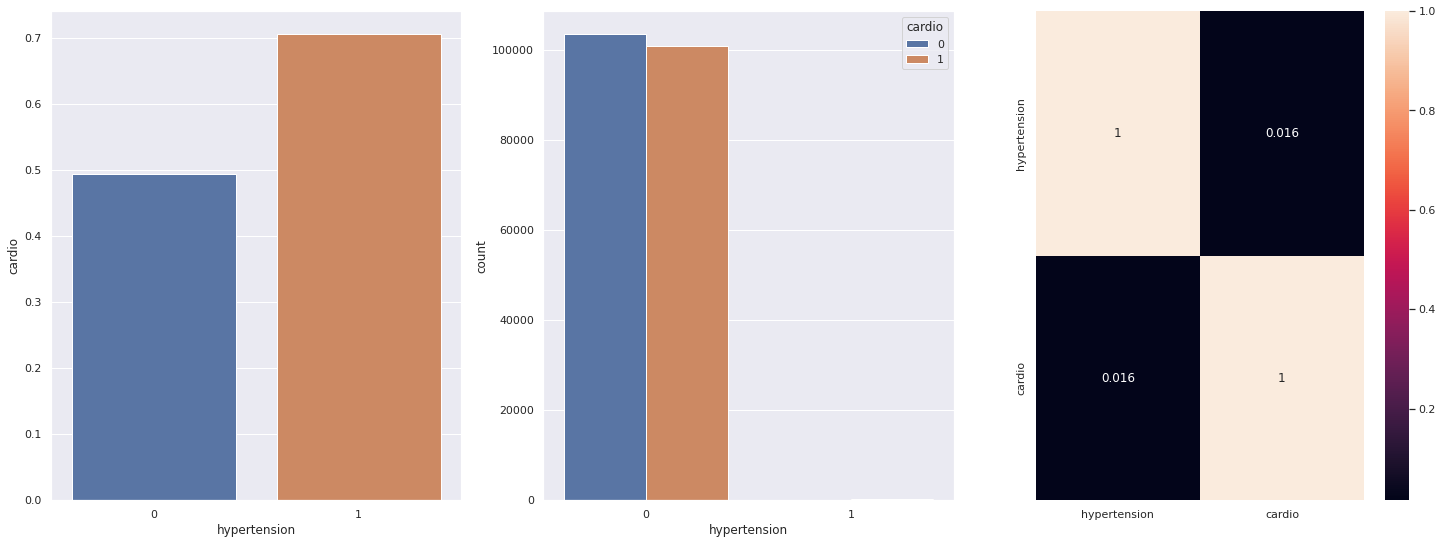

In [254]:
aux = df2[['hypertension', 'cardio']].groupby('hypertension').mean().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='hypertension', y='cardio', data=aux);

plt.subplot(1,3,2)
sns.countplot(x='hypertension', hue='cardio', data=df2);

plt.subplot(1,3,3)
sns.heatmap(df2[['hypertension', 'cardio']].corr('pearson'), annot=True);

In [255]:
# Hypertension percentual
df2['hypertension'].value_counts()[1] / df2['hypertension'].value_counts()[0] * 100

0.13932070158972254

##### 5.2.11 - Hypotension, more risk
   False

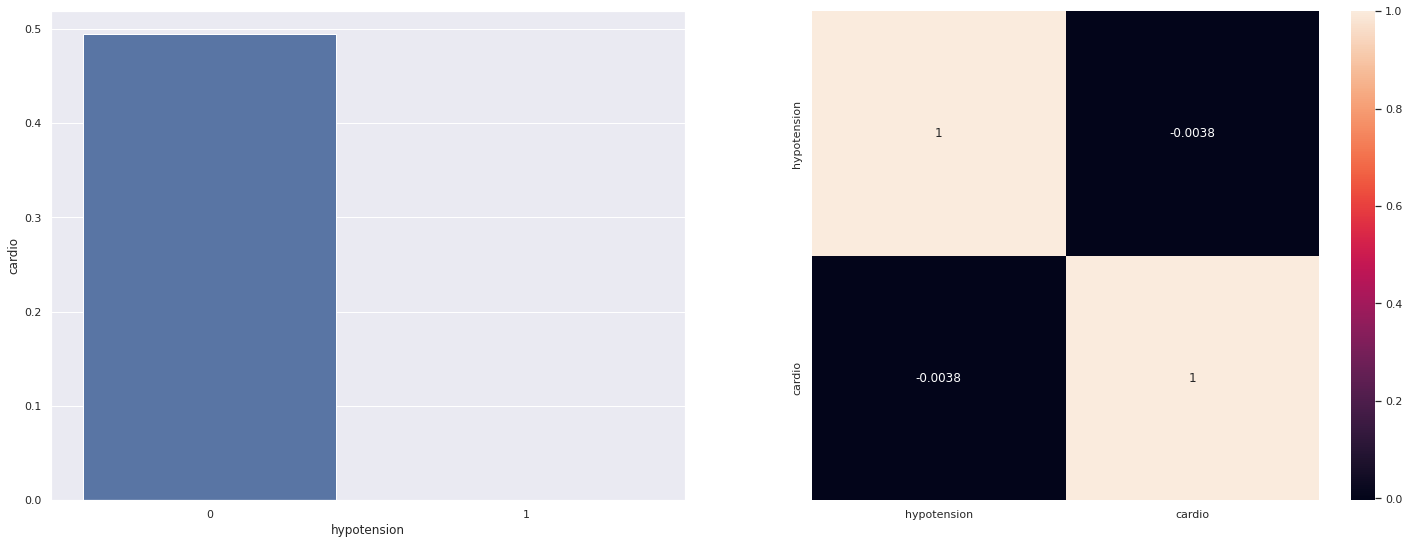

In [256]:
aux = df2[['hypotension', 'cardio']].groupby('hypotension').mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='hypotension', y='cardio', data=aux);

plt.subplot(1,2,2)
sns.heatmap(df2[['hypotension', 'cardio']].corr('pearson'), annot=True);

In [257]:
df2['hypotension'].value_counts()

0    204846
1         3
Name: hypotension, dtype: int64

##### 5.2.12 - BMI - Obesity, more risk
   True

  bmi_level  cardio         0
0         0       0  0.712272
1         0       1  0.287728
2         1       0  0.603304
3         1       1  0.396696
4         2       1  0.503709
5         2       0  0.496291
6         3       1  0.614089
7         3       0  0.385911
  bmi_level    cardio
0         0  0.287728
1         1  0.396696
2         2  0.503709
3         3  0.614089


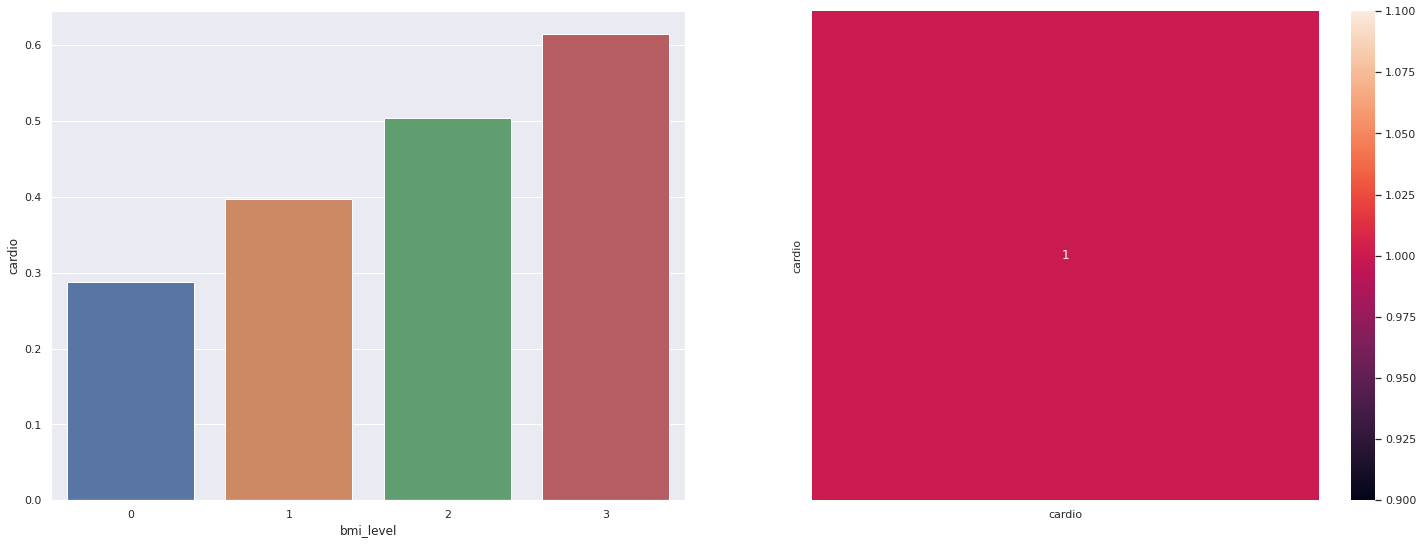

In [258]:
aux = df2[['bmi_level', 'cardio']].groupby('bmi_level').value_counts(normalize=True).reset_index()
print(aux)
aux = df2[['bmi_level', 'cardio']].groupby('bmi_level').mean().reset_index()
print(aux)

plt.subplot(1,2,1)
sns.barplot(x='bmi_level', y='cardio' ,data=aux);

plt.subplot(1,2,2)
sns.heatmap(df2[['bmi_level', 'cardio']].corr('pearson'), annot=True);

# aux1 = df2[(df2['cardio'] ==1)]
# aux2 = df2[(df2['cardio'] ==2) ]


##### 5.2.13 - Gender 2 has more risk
   False

In [259]:
aux = df2[['gender', 'cardio']].groupby('gender').value_counts(normalize=True).reset_index()
print(aux)
aux = df2[['gender', 'cardio']].groupby('gender').mean().reset_index()
print(aux)

   gender  cardio         0
0       1       0  0.508181
1       1       1  0.491819
2       2       0  0.501381
3       2       1  0.498619
   gender    cardio
0       1  0.491819
1       2  0.498619


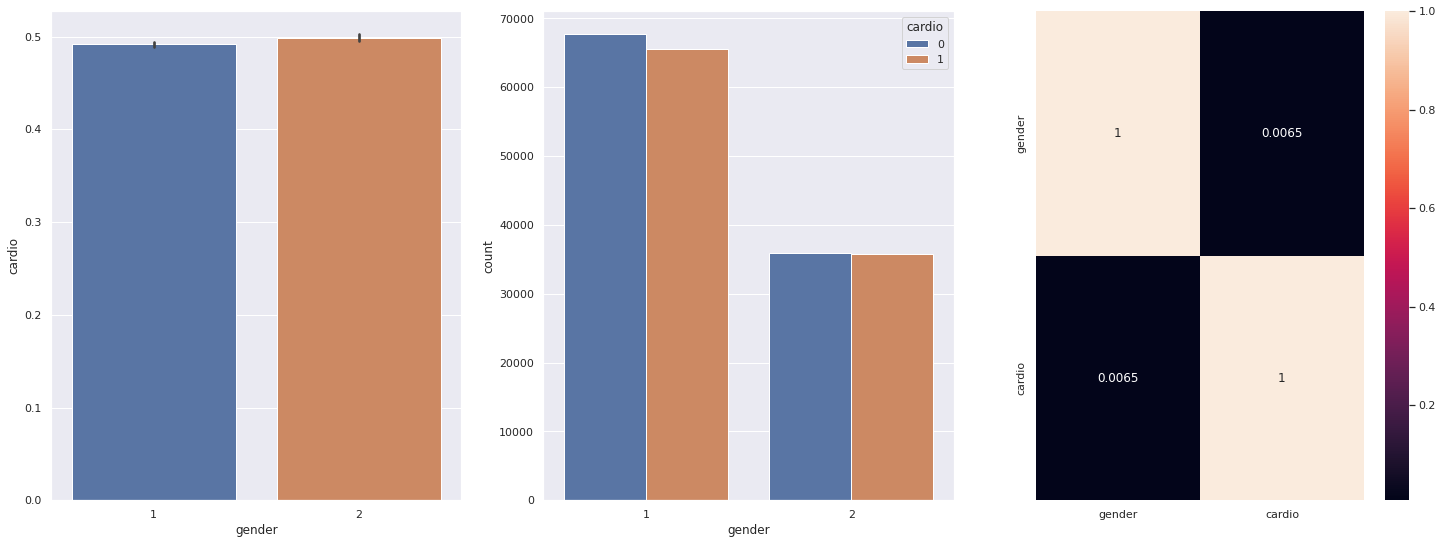

In [260]:
plt.subplot(1,3,1)
sns.barplot(x='gender', y='cardio', data=df2)
plt.subplot(1,3,2)
sns.countplot(x='gender', hue='cardio', data=df2 );
plt.subplot(1,3,3)
sns.heatmap(df2[['gender', 'cardio']].corr('pearson'), annot=True);


##### 5.2.14 - how more weith more risk
   True

In [261]:
aux = df2[['weight_range', 'cardio']].groupby('weight_range').value_counts(normalize=True).reset_index()
print(aux)
aux = df2[['weight_range', 'cardio']].groupby('weight_range').mean().reset_index()
print(aux)

    weight_range  cardio         0
0           0.50       0  0.715779
1           0.50       1  0.284221
2           0.75       0  0.562222
3           0.75       1  0.437778
4           1.00       1  0.576456
5           1.00       0  0.423544
6           1.25       1  0.681986
7           1.25       0  0.318014
8           1.50       1  0.752500
9           1.50       0  0.247500
10          1.75       1  0.571429
11          1.75       0  0.428571
12          2.00       1  0.653061
13          2.00       0  0.346939
   weight_range    cardio
0          0.50  0.284221
1          0.75  0.437778
2          1.00  0.576456
3          1.25  0.681986
4          1.50  0.752500
5          1.75  0.571429
6          2.00  0.653061


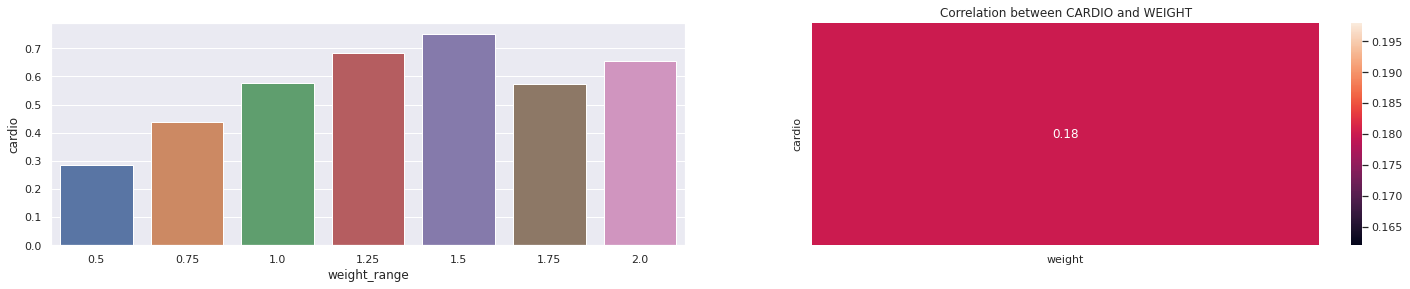

In [262]:
aux = df2[['weight_range', 'cardio']].groupby('weight_range').mean().reset_index()

grid = GridSpec(2,2)

plt.subplot(grid[1,0])
sns.barplot(x='weight_range', y='cardio', data=aux);
                 
plt.subplot(grid[1,1])
plt.title('Correlation between CARDIO and WEIGHT')
pointb = pointbiserialr(df2['weight'], df2['cardio']).correlation
sns.heatmap(pd.DataFrame({'weight':pointb}, index=['cardio']), annot=True);

### 5.3 - Multivariate Analysis

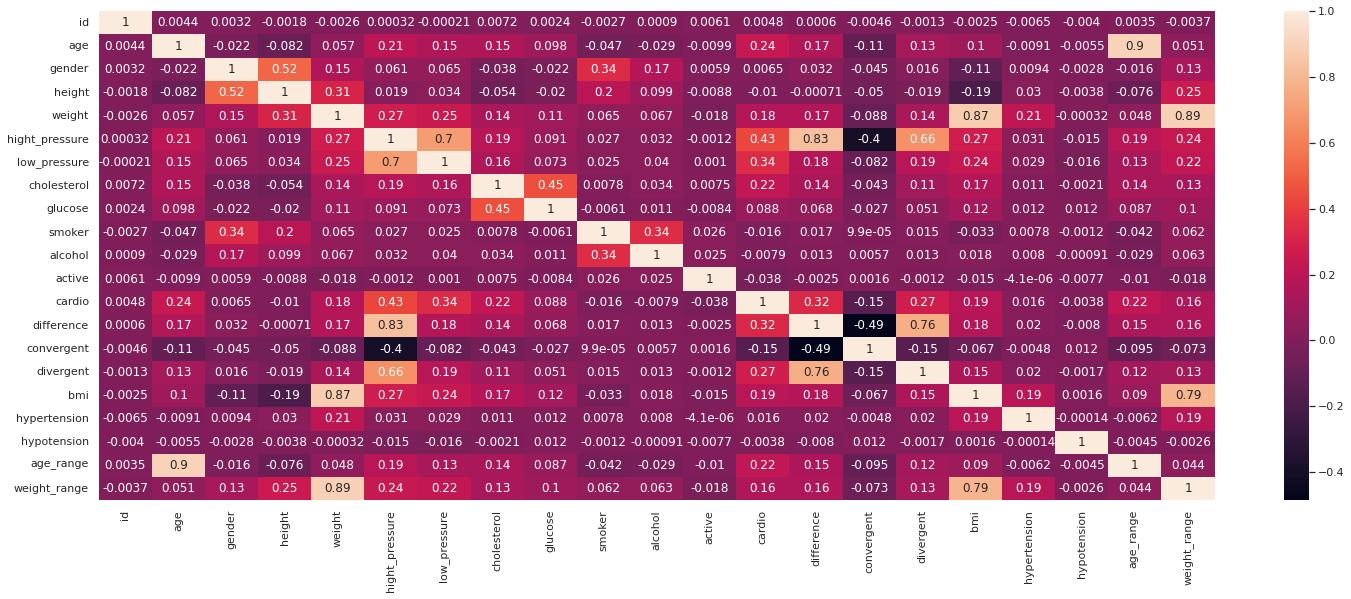

In [263]:
sns.heatmap(df2.corr(), annot=True);

## 6.0 - Data Preparation

In [264]:
df3=df2.copy()

### 6.2 - Normalization

If the data is normal/gaussian distribution
<p>(item - média) / desvio padrão</p>

### 6.3 - Rescaling

If the data it's **NOT** gaussian distribution, gaussian is egual normal distribution

In [265]:
## The features that it's binary yet, it's not necessary transform
## If has the relevant outlier it's should use to RobustScaler else MinMaxScaler

mms = MinMaxScaler()
rs = RobustScaler()

# age
df3['age'] = mms.fit_transform(df3[['age']].values)
pickle.dump(mms, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\age_scaling.pkl', 'wb'))

# height         
df3['height'] = rs.fit_transform(df3[['height']].values)
pickle.dump(rs, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\height_scaling.pkl', 'wb'))

# weight
df3['weight'] = rs.fit_transform(df3[['weight']].values)
pickle.dump(rs, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\weight_scaling.pkl', 'wb'))

# low_pressure   
df3['low_pressure'] = rs.fit_transform(df3[['low_pressure']].values)
pickle.dump(rs, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\low_pressure_scaling.pkl', 'wb'))

#hight_pressure
df3['hight_pressure'] = rs.fit_transform(df3[['hight_pressure']].values)
pickle.dump(rs, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\hight_pressure_scaling.pkl', 'wb'))

# difference     
df3['difference'] = rs.fit_transform(df3[['difference']].values)
pickle.dump(rs, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\difference_scaling.pkl', 'wb'))

# bmi            
df3['bmi'] = rs.fit_transform(df3[['bmi']].values)
pickle.dump(rs, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\bmi_scaling.pkl', 'wb'))


### 6.4 - Transformation

#### 6.3.1 - Encoding

Transforming category data to numeric

#### 6.3.2 - Nature Transformation

Transforming the data to cycle nature

## 7.0 - Feature Selection

### 7.0 - Split

In [266]:
## Spliting after rescaling

X = df3.drop(['cardio','id'], axis=1).copy()
y = df3['cardio'].copy()
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

### 7.1 - Boruta

In [267]:
#same pararameter from item 8.0
x_boruta = x_train.values
y_boruta = y_train.ravel()

#mdl = RandomForestClassifier(n_estimators='auto', random_state=42, n_jobs=-1)
mdl = RandomForestClassifier(n_jobs=-1)



In [268]:
# # Defining Boruta
# boruta = BorutaPy(mdl, n_estimators='auto', verbose=2, random_state=42).fit(x_boruta, y_boruta)

In [269]:
# cols_selected = boruta.support_.tolist()
# cols_selected_boruta = x_train.iloc[:, cols_selected].columns.to_list()
# cols_selected_boruta

In [270]:
x_train = x_train[['bmi', 'weight', 'hight_pressure', 'low_pressure', 'cholesterol', 'age', 'divergent', 'difference']].copy()
x_valid = x_valid[['bmi', 'weight', 'hight_pressure', 'low_pressure', 'cholesterol', 'age', 'divergent', 'difference']].copy()

## 8.0 - Machine learning

### 8.1 - Baseline

The baseline is the "status quo", between **55%** and **65%** of **PRECISION** Score

### 8.2 - Random Forest

In [273]:
mdl = RandomForestClassifier(n_estimators=150, verbose=1,random_state=42).fit(x_train, y_train)
mdl_name = mdl.__repr__()
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df3_score_rf = metrics_score(y_valid, y_hat, mdl_name)
df3_score_rf['accuracy_cv'] = mean(n_scores)
df3_score_rf['accuracy_cv_std'] = std(n_scores)
df3_score_rf

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   35.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    6.7s finished


,mdl_name,accuracy,precision,recall,accuracy_cv,accuracy_cv_std
0,"RandomForestClassifier(n_estimators=150, rando...",0.918021,0.923079,0.909687,0.908427,0.002321


### 8.3 - GBDT

<a style="font-size:10px" href="https://machinelearningmastery.com/gradient-boosting-machine-ensemble-in-python/"> Font Coding</a>

In [278]:
mdl = GradientBoostingClassifier().fit(x_train, y_train)
mdl_name = mdl.__repr__()
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df3_score_gbdt = metrics_score(y_valid, y_hat, mdl_name)
df3_score_gbdt['accuracy_cv'] = mean(n_scores)
df3_score_gbdt['accuracy_cv_std'] = std(n_scores)
df3_score_gbdt

,mdl_name,accuracy,precision,recall,accuracy_cv,accuracy_cv_std
0,GradientBoostingClassifier(),0.736262,0.752974,0.692891,0.733278,0.003131


### 8.4 - Logistic Regression

In [279]:
mdl = LogisticRegression(random_state=42).fit(x_train, y_train)
mdl_name = mdl.__repr__()
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df3_score_lr = metrics_score(y_valid, y_hat, mdl_name)
df3_score_lr['accuracy_cv'] = mean(n_scores)
df3_score_lr['accuracy_cv_std'] = std(n_scores)
df3_score_lr

,mdl_name,accuracy,precision,recall,accuracy_cv,accuracy_cv_std
0,LogisticRegression(random_state=42),0.727687,0.755748,0.662226,0.724052,0.002984


### 8.5 - XGBClassifier

<a style="font-size:10px" href="https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/"> Font Coding</a>

In [280]:
mdl = XGBClassifier().fit(x_train, y_train)
mdl_name = mdl.__repr__()
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df3_score_xgbc = metrics_score(y_valid, y_hat, mdl_name)
df3_score_xgbc['accuracy_cv'] = mean(n_scores)
df3_score_xgbc['accuracy_cv_std'] = std(n_scores)
df3_score_xgbc

,mdl_name,accuracy,precision,recall,accuracy_cv,accuracy_cv_std
0,"XGBClassifier(base_score=None, booster=None, c...",0.750972,0.772273,0.702552,0.747628,0.002551


### 8.6 - KNClassifier

In [281]:
mdl = KNeighborsClassifier().fit(x_train, y_train)
mdl_name = mdl.__repr__()
yhat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df3_score_knc = metrics_score(y_valid, y_hat, mdl_name)
df3_score_knc['accuracy_cv'] = mean(n_scores)
df3_score_knc['accuracy_cv_std'] = std(n_scores)
df3_score_knc

,mdl_name,accuracy,precision,recall,accuracy_cv,accuracy_cv_std
0,KNeighborsClassifier(),0.750972,0.772273,0.702552,0.75664,0.003049


### 8.7 - LGBMClassifier

In [282]:
mdl = LGBMClassifier().fit(x_train, y_train)
mdl_name = mdl.__repr__()
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df3_score_lgbmc = metrics_score(y_valid, y_hat, mdl_name)
df3_score_lgbmc['accuracy_cv'] = mean(n_scores)
df3_score_lgbmc['accuracy_cv_std'] = std(n_scores)
df3_score_lgbmc

,mdl_name,accuracy,precision,recall,accuracy_cv,accuracy_cv_std
0,LGBMClassifier(),0.742413,0.762322,0.694606,0.737816,0.002799


### 8.8 - Hyperparameters

In [283]:
parameters = {'learning_rate':[0.01, 0.08], 
    'n_estimators':[100, 150],
    'subsample':[0.08, 0.1, 0.2, 0.6, 0.7, 0.8, 0.9, 1.0], 
    'min_samples_split':[0.3, 0.6, 0.8, 2, 3, 4],
    'min_samples_leaf':[1, 2, 3, 4], 
    'max_depth':[3, 5, 10, 15, 20, 25]}

In [284]:
MAX_EVALS = 10
df3_hyper = pd.DataFrame(columns=['Mean_accuracy', 'Std_accuracy', 'Parameters'])

for i in range(MAX_EVALS):
    print(f'evals: {i}')
    
    hp = {k:sp(v, 1)[0] for k, v in parameters.items()}
    print(f'Hyperparameters: {hp}')
    mdl = GradientBoostingClassifier(
        learning_rate=hp['learning_rate'], n_estimators=hp['n_estimators'],
        subsample=hp['subsample'], min_samples_split=hp['min_samples_split'],
        min_samples_leaf=hp['min_samples_leaf'], max_depth=hp['max_depth'],
        loss='deviance', random_state=42
        ).fit(x_train, y_train)
    print('trained...')
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    print('crossvalidation finished')
    
    df3_cv = pd.DataFrame([[mean(n_scores), std(n_scores), hp]], 
                        columns=['Mean_accuracy', 'Std_accuracy', 'Parameters'])
    
    print(df3_cv)
    df3_hyper = pd.concat([df3_hyper, df3_cv], axis=0)
    
df3_hyper

evals: 0
Hyperparameters: {'learning_rate': 0.01, 'n_estimators': 150, 'subsample': 1.0, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 3}
trained...
crossvalidation finished
   Mean_accuracy  Std_accuracy                                         Parameters
0       0.722615      0.002026  {'learning_rate': 0.01, 'n_estimators': 150, '...
evals: 1
Hyperparameters: {'learning_rate': 0.08, 'n_estimators': 150, 'subsample': 0.1, 'min_samples_split': 0.8, 'min_samples_leaf': 1, 'max_depth': 3}
trained...
crossvalidation finished
   Mean_accuracy  Std_accuracy                                         Parameters
0       0.505502      0.000014  {'learning_rate': 0.08, 'n_estimators': 150, '...
evals: 2
Hyperparameters: {'learning_rate': 0.01, 'n_estimators': 100, 'subsample': 0.9, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 5}
trained...
crossvalidation finished
   Mean_accuracy  Std_accuracy                                         Parameters
0       0.731095      0.

,Mean_accuracy,Std_accuracy,Parameters
0,0.722615,0.002026,"{'learning_rate': 0.01, 'n_estimators': 150, '..."
0,0.505502,0.000014,"{'learning_rate': 0.08, 'n_estimators': 150, '..."
0,0.731095,0.002217,"{'learning_rate': 0.01, 'n_estimators': 100, '..."
0,0.732674,0.002283,"{'learning_rate': 0.01, 'n_estimators': 150, '..."
0,0.877666,0.001215,"{'learning_rate': 0.08, 'n_estimators': 150, '..."
0,0.741716,0.002182,"{'learning_rate': 0.01, 'n_estimators': 150, '..."
0,0.711706,0.002325,"{'learning_rate': 0.01, 'n_estimators': 150, '..."
0,0.752468,0.002118,"{'learning_rate': 0.08, 'n_estimators': 100, '..."
0,0.711706,0.002325,"{'learning_rate': 0.01, 'n_estimators': 150, '..."
0,0.724628,0.001886,"{'learning_rate': 0.01, 'n_estimators': 150, '..."


### 8.9 - Final Model

In [285]:
final_model = GradientBoostingClassifier().fit(x_train, y_train)
pickle.dump(final_model, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\age_scaling.pkl', 'wb'))

## 9.0 - Metrics

### 9.1 - Validation

In [286]:
df3_all_scores_sbs = pd.concat([df3_score_rf, df3_score_gbdt, df3_score_lr, df3_score_xgbc, df3_score_knc, df3_score_lgbmc], axis=0)
df3_all_scores_sbs

,mdl_name,accuracy,precision,recall,accuracy_cv,accuracy_cv_std
0,"RandomForestClassifier(n_estimators=150, rando...",0.918021,0.923079,0.909687,0.908427,0.002321
0,GradientBoostingClassifier(),0.736262,0.752974,0.692891,0.733278,0.003131
0,LogisticRegression(random_state=42),0.727687,0.755748,0.662226,0.724052,0.002984
0,"XGBClassifier(base_score=None, booster=None, c...",0.750972,0.772273,0.702552,0.747628,0.002551
0,KNeighborsClassifier(),0.750972,0.772273,0.702552,0.756640,0.003049
0,LGBMClassifier(),0.742413,0.762322,0.694606,0.737816,0.002799


### 9.2 - Cross Validation

In [1]:
## all scoring split before scaling

df3_all_scores_cv = pd.concat([df3_score_rf, df3_score_gbdt, df3_score_lr, df3_score_xgbc, 
                              df3_score_knc, df3_score_lgbmc], axis=0)
# rename column 
df3_all_scores_cv.columns = ['mdl_name', 'accuracy', 'precision', 'recall', 'split_before_scaling',
                            'date', 'obs', 'accuracy_cv', 'accuracy_cv_std']

# reordenation from columns
df3_all_scores_cv[['mdl_name', 'accuracy', 'accuracy_cv', 'accuracy_cv_std', 'precision', 
                 'recall', 'split_before_scaling', 'date', 'obs']]

NameError: ignored

**Gradient Boosting it's better**

In [ ]:
# Exporting result from cross validation
pickle.dump(df3_all_scores_cv, file)

### 9.4 - Business Performance

In [ ]:
cost_status_quo = 1000                         ## cost of each diagnostic with operators and machines
percentual_status_quo = (0.55+0.65)/2
revenue_status_quo = int((percentual_status_quo - 0.50)/0.05) * 500
result_status_quo = revenue_status_quo - cost_status_quo

cost_future = 0
standard = 0.006706
percentual_future = (0.752+0.765)/2
revenue_future = int((percentual_future - 0.50)/0.05) * 500  
result_model_future = revenue_future - cost_future   

In [ ]:
pd.concat([pd.Series(result_status_quo), pd.Series(result_model_future)]).reset_index().T.plot(kind='bar');

## 10.0 - Deploy

### 10.1 - Class

In [ ]:
import pandas as pd
import numpy as np
import json
import pickle

# this file will be a handler "API"
class Cardio_Catch_Diseases(object):
    def __init__(self):
        self.home_path              = '/home/python/Documents/Projects/pa001_cardio_catch_diseases/'
        self.age_scaling            = pickle.load(open(self.home_path + 'parameters/age_scaling.pkl', 'rb'))
        self.bmi_scaling            = pickle.load(open(self.home_path + 'parameters/bmi_scaling.pkl', 'rb'))
        self.difference_scaling     = pickle.load(open(self.home_path + 'parameters/difference_scaling.pkl', 'rb'))
        self.height_scaling         = pickle.load(open(self.home_path + 'parameters/height_scaling.pkl', 'rb'))
        self.hight_pressure_scaling = pickle.load(open(self.home_path + 'parameters/hight_pressure_scaling.pkl', 'rb'))
        self.low_pressure_scaling   = pickle.load(open(self.home_path + 'parameters/low_pressure_scaling.pkl', 'rb'))
        self.weight_scaling         = pickle.load(open(self.home_path + 'parameters/weight_scaling.pkl', 'rb'))
        self.gender_encoder         = pickle.load(open(self.home_path + 'parameters/gender_encoder.pkl', 'rb'))


    
    def data_cleaning(self, df3):
        '''df3: is the input data from user on website'''


        # height - change centimeters to meters
        df3['height'] = (df3['height'] / 100)

        return df3

    def feature_engineering(self, df3):
        '''Get the dataframe from data cleaning and create a new features'''


        # feature engineering
        df3['difference'] = df3['hight_pressure'] - df3['low_pressure']
        df3['convergent'] = df3['difference'].apply(lambda x: 1 if x <= 30 else 0)
        df3['divergent'] = df3['difference'].apply(lambda x: 1 if x >= 60 else 0)
        df3['bmi'] = (df3['weight']/(df3['height'] * df3['height']))
        df3['bmi_level'] = df3['bmi'].apply(lambda x: 
                                                      'underweight' if x <= 18.5 else
                                                      'normal'      if x >  18.5 and x <= 24.9 else
                                                      'overweight'  if x >= 25.0 and x <= 29.9 else
                                                      'obesity')
        df3['hypertension'] = df3.apply(lambda x: 1 if x[4] >=140 and x[5] >= 90 else 0, axis=1)
        df3['hypotension'] = df3.apply(lambda x: 1 if x[4] <=90 and x[5] <= 60 else 0, axis=1)
        df3['age_range'] = df3['age'].apply(lambda x: 'age_0_50'    if x <= 50 
                                                           else 'age_51_59'   if x >= 51 and x <= 59 
                                                           else 'age_60_over' if x >= 60 
                                                           else x)

        df3['weight_range'] = df3['weight'].apply(
            lambda x:   0.50 if x <= 50  else
                        0.75 if x >= 51  and x <= 75 else
                        1.00 if x >= 76  and x <= 100 else
                        1.25 if x >= 101 and x <= 125 else
                        1.50 if x >= 126 and x <= 150 else
                        1.75 if x >= 151 and x <= 175 else 2.00)

        # Data Filtering rows, values or columns
        df3 = df3.drop('id', axis=1)

        return df3


    def data_rescaling(self, df3):
        '''
        Rescaling data
        Return: json file with x_test data to input the prediction
        '''


        # Transforming data to will be in correct data scaler to input at model
        df3['age']            = self.age_scaling.transform(df3[['age']].values)
        df3['height']         = self.height_scaling.transform(df3[['height']].values)
        df3['weight']         = self.weight_scaling.transform(df3[['weight']].values)
        df3['low_pressure']   = self.low_pressure_scaling.transform(df3[['low_pressure']].values)
        df3['hight_pressure'] = self.hight_pressure_scaling.transform(df3[['hight_pressure']].values)
        df3['difference']     = self.difference_scaling.transform(df3[['difference']].values)
        df3['bmi']            = self.bmi_scaling.transform(df3[['bmi']].values)
        df3['gender']         = self.gender_encoder.transform(df3[['gender']].values)
        df3['age_range']      = df3['age_range'].map(
            {'age_0_50':1, 'age_51_59':1, 'age_60_over':3})
        df3['bmi_level']      = df3['bmi_level'].map(
            {'underweight':1, 'normal':2, 'overweight':3, 'obesity':4})

        # Deleting target
        x_test = df3.drop('cardio', axis=1).copy()
        #data_json = json.dumps(x_test.to_dict(orient='records')) # converto to json

        return x_test

### 10.2 - Input Simulation

In [ ]:
import pandas as pd

def input_simulation():
    # inputs from user
    
    age = input('age: ')
    gender = int(input('gender: '))
    height = int(input('height: '))
    weight = float(input('weight: '))
    ap_hi = int(input('hight_pressure: '))
    ap_lo = int(input('low_pressure: '))
    cholesterol = int(input('cholesterol (1,2 or 3): '))
    gluc = int(input('glucose (1,2 or 3): '))
    smoke = int(input('smoker: '))
    alco = int(input('alcohol: '))
    active = input('active: ')

    # replacing columns names
    new_col = ['id', 'age', 'gender', 'height', 'weight', 'hight_pressure', 'low_pressure',
               'cholesterol', 'glucose', 'smoker', 'alcohol', 'active', 'cardio']

    # getting data and converting to dataframe
    df3_inputed = [[1, age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, 0,]]
    df3 = pd.DataFrame(df3_inputed, columns=new_col)

    # datatypes transformations
    df3['age'] = df3['age'].astype('int64')
    df3['gender'] = df3['gender'].astype('int64')
    df3['height'] = df3['height'].astype('int64')
    df3['weight'] = df3['weight'].astype('float64')
    df3['hight_pressure'] = df3['hight_pressure'].astype('int64') 
    df3['low_pressure'] = df3['low_pressure'].astype('int64') 
    df3['cholesterol'] = df3['cholesterol'].astype('int64')
    df3['glucose'] = df3['glucose'].astype('int64')
    df3['smoker'] = df3['smoker'].astype('int64') 
    df3['alcohol'] = df3['alcohol'].astype('int64')
    df3['active'] = df3['active'].astype('int64')
    df3['cardio'] = df3['cardio'].astype('int64')

    return json.dumps(df3.to_dict(orient='records'))

### 10.2 - API / Handler

In [ ]:
import pickle
import pandas as pd
import numpy as np
from flask import Flask, request, Response
from ccd.ccd import Cardio_Catch_Diseases
import json

# loading model trained from pickle file
with open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/model/model_trained.pkl', 'rb') as file:
    model = pickle.load(file)

# initialized API
app = Flask(__name__)

@app.route('/ccd/predict', methods=['POST'])
def ccd_predict():
    '''
    ccd: Cardio Catch Diseases
    This function it will be create the API request, where the user will be input the user data that 
    will used to data_cleaning(), data_engineering(), data_scaler() 
    this functions will be return the dataframe 'x_est', that will be used to predict
    Return: Prediction "array"
    '''
    
    test_json = request.get_json()
        
    if test_json:
        if isinstance(test_json, dict): # Unique Example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # multiple Example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instantiate CCD class
        pipeline = Cardio_Catch_Diseases()
        # cleaning data
        test_raw_cleaned = pipeline.data_cleaning(test_raw)
        # creating derivates to new features
        test_raw_features = pipeline.feature_engineering(test_raw_cleaned)        
        
        # preparing data to model
        test_raw_selected = pipeline.data_rescaling(test_raw_features)
        
        y_hat = model.predict(test_raw_selected)
        test_raw['prediction'] = y_hat.copy()
        return test_raw.to_json(orient='records')
    
    else:
        return Response( "{}", status=200, mimetype='application/json')

    
if __name__=='__main__':
    app.run('0.0.0.0')

### 10.2 - API Request Tester

In [ ]:
import requests

# Input data user
data = input_simulation()

# API request
url = "https://ccd-model.herokuapp.com/ccd/predict"
header = {'Content-type': 'application/json'}

response_ccd = requests.post(url, data=data, headers=header)
print(f'Status Code: {response_ccd.status_code}')

df3_response = pd.DataFrame(response_ccd.json(), columns=response_ccd.json()[0].keys())

# Loading json to Dataframe
df3_new = pd.DataFrame(json.loads(data))

# converting to back the original datatype
df3_new['age'] = df3_new['age'] * 365

# getting prediction
df3_new['cardio'] = df3_response['cardio'].copy()

# getting current time in seconds since the Epoch.
# convert to normal date use time.ctime(time.time())
df3_new['id'] = time.time()

# Insert into database
insert_database_values(df3_new)

df3_response

## 11.0 - Dashboard - PowerBI

In [ ]:
# Connecting sqlite database
import pandas as pd
from sqlalchemy import create_engine

new_col = ['id', 'age', 'gender', 'height', 'weight', 'hight_pressure', 'low_pressure',
           'cholesterol', 'glucose', 'smoker', 'alcohol', 'active', 'cardio']

engine = create_engine('sqlite:///Y:\\pa001_cardio_catch_diseases\\ccd.db', echo=False)
df3 = engine.execute('SELECT * FROM patients').fetchall()
df3 = pd.DataFrame(df3, columns=new_col)

# Data Preparation/transformation

